<a href="https://colab.research.google.com/github/Ken-huea/image-recognition/blob/main/%E7%94%B7%E5%A5%B3%E8%AD%98%E5%88%A5%E5%AE%9F%E8%A3%85%E2%91%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 問題

- 画像識別は、自動販売機や防犯カメラに写った人物の性別、年齢層などを自動で判定することなどにも使われており、顧客分析や指名手配犯の追跡などに利用されています。
- 今回はそのファーストステップとして男女を識別をするモデルを実装してみます。

## 実行

### データのロード

In [ ]:
# 初めの一回だけ実装⇒これでデータのロード。
import urllib.request
import zipfile
import os

# URLを指定
url = "https://storage.googleapis.com/tutor-contents-dataset/6100_gender_recognition_data.zip"
save_name = url.split('/')[-1]

# ダウンロードする
mem = urllib.request.urlopen(url).read()

# ファイルへ保存
with open(save_name, mode='wb') as f:
    f.write(mem)

# zipファイルをカレントディレクトリに展開する
zfile = zipfile.ZipFile(save_name)
zfile.extractall('.')

画像ファイル名の取得。この時点ではまだ、データそのものを取得したわけではありません。

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers

%matplotlib inline

# データのファイル名の取得
path_male = os.listdir('/content/6100_gender_recognition_data/male')
path_female = os.listdir('/content/6100_gender_recognition_data/female')

取得した情報の確認と整理

In [ ]:
print(len(path_male))        # 499枚のjpeg画像　  リスト
print(len(path_female))      # 499枚のjpeg画像　  リスト
print(type(path_male[0]))    # このままじゃstr ⇒ listに変換。
print(path_male[0])          # この状態では画像データではなく、ファイル名。

499
499
<class 'str'>
Ahmet_Necdet_Sezer_0002.jpg


### リサイズ処理
メモ：データを大きくして読み込むと時間はかかるがより良い結果のモデルができます。

(50, 50, 3)より(150, 150, 3)の方が良い。繰り返すようですが、時間はかかるのでGPU推奨。

① path maleの数(499)回分だけfor文を回します。

② ダウンロードしたファイルmaleの中身を順々に取り出します。⇒

③ resize処理を行います。

④ リストに追加します。

<font color="red">更に分かりやすく</font>：
maleフォルダの一番最初[0]を確認してみると…。


In [ ]:
print(path_male[0])

Alejandro_Toledo_0037.jpg


この画像を読み込んでリサイズをしています。

次も同様。このように順々にパスを指定し画像をどんどん読込みリサイズしているという訳です。

In [ ]:
print(path_male[1])
print(path_male[2])
print(path_male[3])
print(path_male[4])

Alex_Penelas_0002.jpg
Alexander_Lukashenko_0001.jpg
Andre_Agassi_0003.jpg
Adel_Al-Jubeir_0002.jpg


In [ ]:
# 空のリストを作成します。
img_male = []
img_female = []

# 仕組みは上の①～④を参照
for i in range(len(path_male)):
    img = cv2.imread('/content/6100_gender_recognition_data/male/' + path_male[i])
    img = cv2.resize(img, (150,150))
    img_male.append(img)

for i in range(len(path_female)):
    img = cv2.imread('/content/6100_gender_recognition_data/female/' + path_female[i])
    img = cv2.resize(img, (150,150))
    img_female.append(img)

# path⇒読み込んで⇒画像データ

In [ ]:
img_male[0].shape  # 形状を確認します。⇒良さそう。(50, 50, 3)  

(150, 150, 3)

### 訓練データとテストデータの生成。
img_maleとimg_femaleを足し合わせ、それをシャッフルし訓練とテストに分割。

因みにこのデータ分割方法は数ある内の一つです。後でtrain_test_splitを用いた方法もお伝えします。

現在は男性画像はimg_maleに、女性画像はimg_femaleにあるんですよね。

それを足し合わせて、シャッフルすれば一つの大きなデータになります。

これを訓練データとテストデータに分割しましょう。

このコードについて少し説明
```
y =  np.array([0]*len(img_male) + [1]*len(img_female)) 
```
img_maleの枚数＊0　と　img_femaleの枚数＊1。

そうする事により、それぞれの正解ラベルが生成されyに格納されるでしょう。


In [ ]:
X = np.array(img_male + img_female) # male  female 画像リストを足し合わせましょう。⇒画像データ(男女)

y =  np.array([0]*len(img_male) + [1]*len(img_female)) # これに対するラベル 0 to  ⇒yラベル(男女)

# 試しに確認してみてください
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

このまま分割したら流石にダメですよね。良い訓練データというのは偏りがないものです。

現段階では前半が0で後半が1なのでまずはシャッフルしましょう。


In [ ]:
# そこでランダムに。0～997(画像の総数)の数字が出来上がります⇒　これをシャッフル。
rand_index = np.random.permutation(np.arange(len(X)))

X = X[rand_index]
y = y[rand_index]
rand_index       # 確認してみましょう。かなりシャッフルされていますね。

array([914, 740, 234, 222, 882, 462, 419, 543, 583, 481, 916, 805, 455,
       164, 127, 176, 590, 470, 310, 554, 661, 107, 644, 115,  90,   2,
       990, 410, 596, 233, 848, 255, 636,  20, 689, 494, 568, 425, 873,
       274, 191, 623, 370, 781, 588,  61, 654,  43, 239,  53, 782, 303,
       764, 171, 754, 836, 209, 829, 294, 770, 966, 355, 670, 145, 393,
       187, 994, 254, 450, 142, 641, 775, 850, 457, 428, 318, 358, 528,
       334, 658, 542, 839, 132, 838, 981, 938, 495, 101, 975, 801, 344,
       605,  85, 342, 917, 867, 289, 404, 639, 517, 513, 560, 872, 136,
       620, 268, 365, 808, 440, 505, 247, 703, 715, 830, 610, 665, 448,
       541, 913, 861,  17, 736, 216, 899, 118, 397, 660, 520, 525, 849,
       179, 532, 659, 201, 832, 842, 113, 214, 878, 807,   7, 194, 739,
       766, 207, 692, 603, 238, 894, 814,  45, 224, 745, 643, 236, 163,
       673, 497, 471,  65, 347, 547, 437, 973, 459, 726, 791, 157,  88,
       227, 423, 129, 535, 584, 563, 311, 170, 186, 219, 856,  6

シャッフルが確認できたので<font color="red">データの分割</font>を行いましょう。

今回のデータ分割はシンプルなコード。訓練データが80％。残り20％がテストデータにしたいとき



```
train_test_split
```
以外で結構よく見かける分割記法。たまに使用するので頭の片隅に


In [ ]:
# データの分割

X_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(y)*0.8)]
X_test = X[int(len(X)*0.8):]
y_test = y[int(len(y)*0.8):]

In [ ]:
# 分割結果をshapeで確認して。
X_train.shape,y_train.shape,X_test.shape,y_test.shape,

((798, 150, 150, 3), (798,), (200, 150, 150, 3), (200,))

一応均等に分けられているか、簡単に確認しておきましょう。

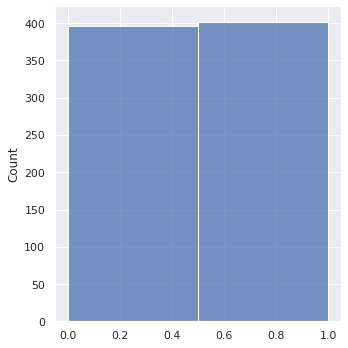

In [ ]:
# ヒストグラム作成.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.show()
sns.displot(y_train, bins =2,kde=False)

# まあ良いでしょう。

分割された正解ラベルをきちんと<font color="red">カテゴリカル変数</font>One Hot Encording しておきましょう。

In [ ]:
y_train

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,

In [ ]:
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

# print(y_test)
print(y_train)


[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


### モデル構築

今回も転移学習vgg16を用いてみましょう。

今回は以前転移学習をした際のモデルをそのまま流用している部分が多いですが、精度向上の為

<font color="red">あらゆる部分をチューニング</font>してみるのも良いかもしれません。

In [ ]:
# モジュールのインポート
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#input_tensorの定義をして、vggのImageNetによる学習済みモデルを作成してください

# 画像サイズを指定。 vgg16の変数を見てください。
input_tensor = Input(shape=(150, 150, 3))

# モデルvgg16を持っていきます。以前の転移学習コードをそのまま流用。
model_vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

model_vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
# 特徴量抽出部分のモデルを作成しています ⇒ これも以前使用した部分を使用。
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg16.output_shape[1:]))  # flattenで1次元配列化
top_model.add(Dense(256, activation='sigmoid'))                   # reluにしてみても良い精度は出そう？ relu or sigmoid
top_model.add(Dropout(0.5))                                       # dropout 
top_model.add(Dense(2, activation='softmax'))                     # 出力層は0,1なので「２」ですよね。

In [ ]:
# そしてこれでもいかがでしょうか？sigmoidではなくrelu関数を使用してみました。是非お好みで。

top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))

連結しちゃいましょう。インポートしたものと、自分で構築したものを。

In [ ]:
#連結するコード。
model = Model(inputs =model_vgg16.input,outputs=top_model(model_vgg16.output))

# inputs =model_vgg16.input
# outputs=top_model(model_vgg16.output)

vgg16から持ってきた重みも固定しましょう。せっかくの良いモデルなので。

どうやら<font color="red">15 or 19</font>で重みを固定するのがポピュラーみたいですよ？

In [ ]:
# 今回は19で。
for layer in model.layers[:19]:
    layer.trainable = False

model.summaryで確認。　


```
top_model.summary()
```
とで双方確認してみると宜しいかと。



In [ ]:
model.summary()
top_model.summary() # 省略していないバージョン

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# 最後にモデルの入力層のみ確認しておきましょう。
model.input_shape

(None, 150, 150, 3)

### 学習。

<font color="red">コンパイル</font>：モデルの学習を始める前にどのような学習処理を行うか設定するもの。

kerasでは3つ引数を定める必要がある。

- 1,<font color="red">損失関数(loss)</font>

「正解」(ラベル)とモデルによる「予測値」とのズレの大きさを計算するための関数。このずれの大きさを損失と呼ぶ。
この値を最小化もしくは最大化を狙う。
今回は多クラス分類⇒<font color="red">categorical_crossentropy</font>

- 2,<font color="red">最適化アルゴリズム(optimizer)</font>

最適化アルゴリズム:損失関数の値をどれだけ⼩さくできるかの手法。Deep Learningのモデルは重みを持っていて、その重みパラメータを調整し、学習を行う。
その重みをどのように調整するのか、という事。⇒<font color="red">分類は初手adam</font>



- 3,<font color="red">評価関数のリスト(metrics)</font>
​

評価関数のリストはモデルをどのように評価するかを指定します。'accuracy'とは正解率の事。どのぐらいモデルが正解しているかを学習の際に指標としてみるかを指定しています。

In [ ]:
# これどちらでも好きな方どうぞ。　俺は初手 adam で行きます。

# opt = 'adam'
opt = optimizers.SGD(lr=1e-4, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# コンパイルをしています
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
X_train.shape,y_train.shape,X_test.shape,X_test.shape,

((798, 150, 150, 3), (798, 2), (200, 150, 150, 3), (200, 150, 150, 3))

batchサイズを調整して精度を上げてみましょう。今のところ32が良さげかな？
128 256 512 

[参照はこちら](https://www.st-hakky-blog.com/entry/2017/11/16/161805)
[参照はこちら](https://qiita.com/kenta1984/items/bad75a37d552510e4682)


In [ ]:
# ハイパーパラメータ
batch_size = 256  # バッチサイズ 32,64,128,256,512 あたり
epochs = 10       # エポック数(学習の繰り返し回数)
val_split = 0.4   # 訓練データのうちx%をvalidation dataとして分割して使います。
pati_time = 5    # y回学習しても向上しない場合は学習を打ち切ります。

In [ ]:
from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）

    # 構築したモデルで学習（学習データ:trainのうち、10％を検証データ:validationとして使用）
history = model.fit(X_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=1, 
                        validation_split=val_split,
                        callbacks=[
                            callbacks.EarlyStopping(monitor='val_accuracy',patience = pati_time),
                            callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='val_accuracy', save_best_only=True)
                            ]
                    )

Epoch 1/10
2/2 [==============================] - 28s 10s/step - loss: 9.7045 - accuracy: 0.4331 - val_loss: 4.0287 - val_accuracy: 0.5844
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 6.6983 - accuracy: 0.5900 - val_loss: 2.2994 - val_accuracy: 0.7469
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 4.1509 - accuracy: 0.7197 - val_loss: 1.8149 - val_accuracy: 0.8188
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 2.7633 - accuracy: 0.7803 - val_loss: 1.8038 - val_accuracy: 0.8438
Epoch 5/10
2/2 [==============================] - 2s 2s/step - loss: 2.6466 - accuracy: 0.8180 - val_loss: 1.7925 - val_accuracy: 0.8500
Epoch 6/10
2/2 [==============================] - 2s 1s/step - loss: 1.6543 - accuracy: 0.8452 - val_loss: 1.7684 - val_accuracy: 0.8562
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 1.7171 - accuracy: 0.8619 - val_loss: 1.7131 - val_accuracy: 0.8687
Epoch 8/10
2/2 [=======================

### 精度の評価

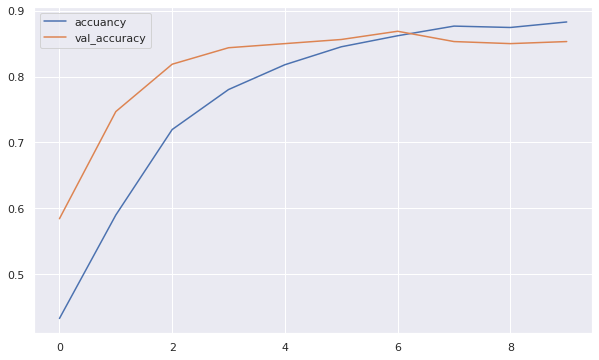

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
# 学習過程のプロット

plt.plot(history.epoch, history.history["accuracy"], label="accuancy")
plt.plot(history.epoch, history.history["val_accuracy"], label="val_accuracy")

plt.legend()

<font color="red">ここの評価はいかがでしょうか？</font>
　
データ数自体が少ないからまあ頑張った方ではないでしょうか。

In [ ]:
# テストデータを用いた最終的、パフォーマンス計測
score = model.evaluate(X_test, 
                            y_test,
                            verbose=0
                            )
 
print("testデータでのloss：",score[0]) # lossの表示。
print("testデータでのaccuracy：",score[1]) # accuracyの表示。

testデータでのloss： 1.8995404243469238
testデータでのaccuracy： 0.8399999737739563


In [ ]:
# 画像を一枚受け取り、男性か女性かを判定して返す関数

def pred_gender(img):
  result = model.predict(img.reshape(1,150,150,3))
  ans = result.argmax()
  if ans ==0:
    return "male"
  else:
    return "female"

パスから順々にデータを読込む。

resizeを行う。

予測するモデルに投入する為、1次元配列にする。

予測する独自関数(pred_gender)に突っ込む。

画像の色調整


これが私が学習させたモデルが予測した結果。　政治家のおじさんをfemaleとか目が死んでんぜ。

(250, 250, 3)
(150, 150, 3)


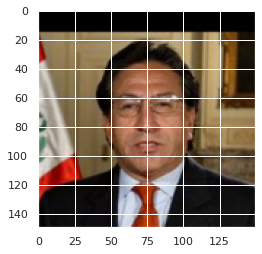

male
(250, 250, 3)
(150, 150, 3)


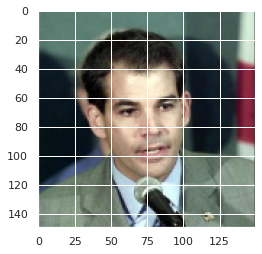

male
(250, 250, 3)
(150, 150, 3)


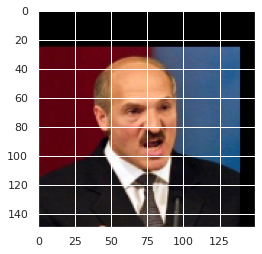

male
(250, 250, 3)
(150, 150, 3)


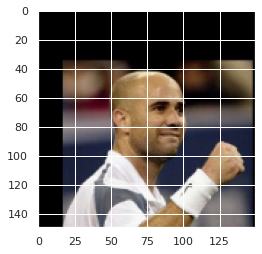

male
(250, 250, 3)
(150, 150, 3)


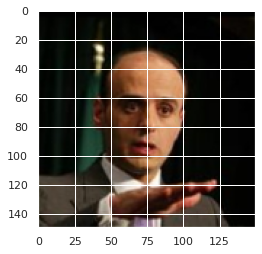

male


In [ ]:
# これではどうでしょう？
for i in range(5):
  img = cv2.imread('./6100_gender_recognition_data/male/' + path_male[i])
  print(img.shape)
  img = cv2.resize(img, (150,150))
  print(img.shape)
  img = np.array(img)
  ans = pred_gender(img)
  b,g,r = cv2.split(img) 
  img = cv2.merge([r,g,b])
  plt.imshow(img)
  plt.show()
  print(pred_gender(img))
  

これが答

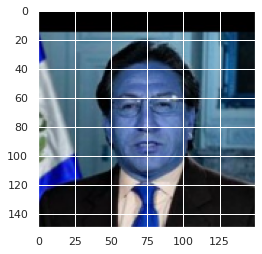

male


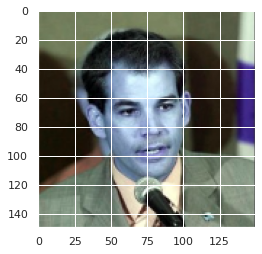

male


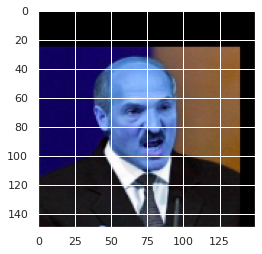

male


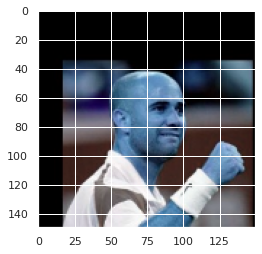

male


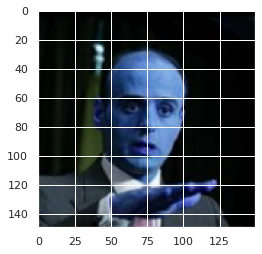

male


In [ ]:
# 色調整 img = cv2.merge([r,g,b])　をスキップしたらこうなります。
# 色がスターウォーズやガーディアンズオブギャラクシーになるけど、あなたが気にならなければ別に？

for i in range(5):
  img = cv2.imread('./6100_gender_recognition_data/male/' + path_male[i])
  img = cv2.resize(img, (150,150))
  img = np.array(img)
  plt.imshow(img)
  plt.show()
  print(pred_gender(img))
  